In [163]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [164]:
## 1 is ProRevenge 0 is MaliciousCompliance

In [165]:
df = pd.read_csv('../data/working_cleaned.csv')

df.drop(columns = 'Unnamed: 0', inplace = True)

In [166]:
df.head()

,selftext,title,subreddit
0,[removed],Does anybody know that one song with a motel a...,0
1,I'm torn between posting this here or one of t...,Quit Instead of Give me Your W9? I'll get your...,0
2,[removed],Black Snow!,0
3,I’m a young male who is coming to the end of t...,So you think everyone wonders why we’re not fr...,0
4,[removed],"Buy Verified PayPal Accounts.USA,UK,CA,Best Pa...",0


In [167]:
(df['selftext'] == '[removed]').sum()

8499

## Removing '[removed]' posts from selftext as those are posts that have been deemed not fit for the category

In [168]:
df = df[df['selftext'] != '[removed]']

In [169]:
(df['selftext'] == '[removed]').sum()

0

### Looking at selftext first

In [170]:
X = df['selftext']
y = df['subreddit']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

## Quick null model

In [171]:
y.value_counts(normalize = True)

0    0.556955
1    0.443045
Name: subreddit, dtype: float64

## looking at vectorized data to see any initial problems

In [172]:
cv = CountVectorizer(stop_words = 'english')

In [173]:
X_train_cv = pd.DataFrame(cv.fit_transform(X_train, y_train).toarray(), columns = cv.get_feature_names_out())

In [174]:
X_train_cv.sum().sort_values(ascending = False).head(15)

just      14925
time      13802
got       11709
day       10416
work      10218
like      10207
didn       9964
told       9923
said       9739
did        8719
know       7260
went       6926
going      6561
people     6250
don        6237
dtype: int64

### Lemmatizer

In [175]:
def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(w) for w in word_tokenize(doc)]

### Simple Logistic regression model w/ vectorizing on SELFTEXT

In [176]:
pipe1 = Pipeline([
    ('cv', CountVectorizer(tokenizer = lemma_tokenizer, stop_words = 'english')),
    ('logr', LogisticRegression(max_iter = 1_000))
])

pipe1.fit(X_train, y_train)

pipe1.score(X_train, y_train), pipe1.score(X_test, y_test)

/Users/danielsun/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


(0.992163204378654, 0.8227611940298507)

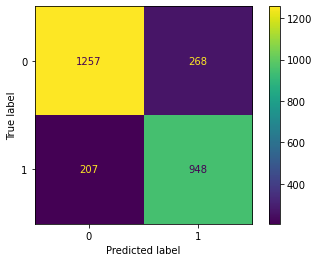

In [177]:
ConfusionMatrixDisplay.from_estimator(pipe1, X_test, y_test)

In [178]:
pipe2 = Pipeline([
    ('cv', CountVectorizer(stop_words = 'english')),
    ('logr', LogisticRegression(max_iter = 1_000))
])

pipe2.fit(X_train, y_train)

pipe2.score(X_train, y_train), pipe2.score(X_test, y_test)

(0.9922875979599453, 0.8261194029850746)

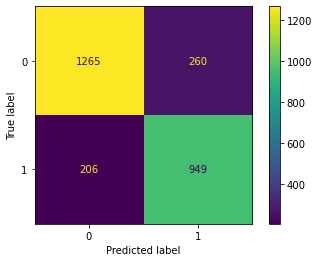

In [179]:
ConfusionMatrixDisplay.from_estimator(pipe2, X_test, y_test)

### Simple Logistic Regression using Title

In [180]:
X = df['title']
y = df['subreddit']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [181]:
pipe2.fit(X_train, y_train)

pipe2.score(X_train, y_train), pipe2.score(X_test, y_test)

(0.9290956586640129, 0.817910447761194)

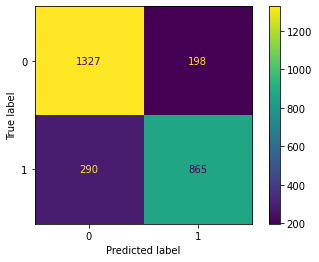

In [149]:
ConfusionMatrixDisplay.from_estimator(pipe2, X_test, y_test)

### Concatting both selftext and title into count vectorizer

In [150]:
renamed = pd.DataFrame(df[['title', 'subreddit']])
renamed.columns = ['text', 'subreddit']
renamed2 = pd.DataFrame(df[['selftext', 'subreddit']])
renamed2.columns = ['text', 'subreddit']

In [151]:
single_df = pd.concat([renamed, renamed2])

In [152]:
single_df

,text,subreddit
1,Quit Instead of Give me Your W9? I'll get your...,0
3,So you think everyone wonders why we’re not fr...,0
5,Want me to drill in style? Gladly!,0
6,I can't let you back in because it would distu...,0
7,"Only one ice cream cone, you say?",0
...,...,...
19212,This happened to me I think a week ago (Saturd...,1
19213,Ok so i posted this on r/nuclearrevenge but i ...,1
19214,A roommate fucked me over before for about two...,1
19215,"So in r/SMG4, you cant ship Mario and Meggy, a...",1


In [153]:
X = single_df['text']
y = single_df['subreddit']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [154]:
pipe2.fit(X_train, y_train)

pipe2.score(X_train, y_train), pipe1.score(X_test, y_test)

(0.9531036198532156, 0.8205223880597015)

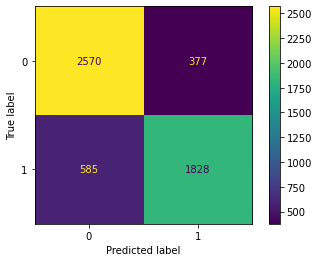

In [155]:
ConfusionMatrixDisplay.from_estimator(pipe2, X_test, y_test)